<a href="https://colab.research.google.com/github/Lipinor/deep_learning_cbpf/blob/master/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Final Project

Final project for the Neural Network subject.

#Setup

Importing the necessary libraries:

In [ ]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Dataset

Here we download the dataset from Kaggle:

In [ ]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


This dataset is composed of credit card transactions made in September 2013 by european customers. The feature 'Time' is the time elapsed between a given transaction and the first one in the dataset (in seconds), 'Amount' is the amount of the transaction, and features 'V1' to 'V28' are numerical input variables whose background is unknown due to confidentiality issues. The classes are 0 (not fraud, or negative) and 1 (fraud, or positive).

Let's see how the classes in the dataset are balanced using the np.bincount function from NumPy. 

In [ ]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n  Total: {}\n  Negative: {} ({:.2f}% of total)\n  Positive: {} ({:.2f}% of total)\n'.format(
    total, neg, 100 * neg / total, pos, 100 * pos / total))

Examples:
  Total: 284807
  Negative: 284315 (99.83% of total)
  Positive: 492 (0.17% of total)



This dataset is heavily imbalanced: only 0.17% of the transactions are frauds. 

#Data Cleaning

We need to clean the data. First, we are going to check if the dataset contains any null values.

In [ ]:
raw_df.isnull().sum() 

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [ ]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Taking a look at some of these features, we notice that the 'Amount' and 'Time' features present high numerical values, which complicates the training and needs a rescaling. We are going to work with the log of the 'Amount' column to reduce its range, and drop the 'Time' feature (for now).

In [ ]:
cleaned_df = raw_df.copy()

# Dropping the 'Time' column
cleaned_df.pop('Time')

# Converting the 'Amount' column to log-space.
eps=0.001 # 0 => 0.1¢
cleaned_df['Log Amount'] = np.log(cleaned_df.pop('Amount')+eps)

cleaned_df[['Log Amount']].describe()

,Log Amount
count,284807.000000
mean,2.942089
std,2.023685
min,-6.907755
25%,1.722945
50%,3.091088
75%,4.345959
max,10.153902


Now it has nicer values for the neural network. 

#Splitting and normalizing the data

We need to split the data between a train, validation and test sets. 

* The train data is used to fit the model. 

* The validation data is not used to fit the model, instead we use it to track  how the loss, accuracy and other metrics evolve using data that the model has not seen yet. This set is important to hel us notice if the model is overfitting.

* The test data is used at the end of the training to see how the model generalizes to new data.

In [ ]:
# Here we use a utility from sklearn to help us split and shuffle the dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Convert the DataFrame into np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [ ]:
neg_train, pos_train = np.bincount(train_labels)
total_train = neg_train + pos_train

neg_val, pos_val = np.bincount(val_labels)
total_val = neg_val + pos_val

neg_test, pos_test = np.bincount(test_labels)
total_test = neg_test + pos_test

print('Train:\n  Total: {}\n  Negative: {} ({:.2f}% of total)\n  Positive: {} ({:.2f}% of total)\n'.format(
    total_train, neg_train, 100 * neg_train / total_train, pos_train, 100 * pos_train / total_train))

print('Validation:\n  Total: {}\n  Negative: {} ({:.2f}% of total)\n  Positive: {} ({:.2f}% of total)\n'.format(
    total_val, neg_val, 100 * neg_val / total_val, pos_val, 100 * pos_val / total_val))

print('Test:\n  Total: {}\n  Negative: {} ({:.2f}% of total)\n  Positive: {} ({:.2f}% of total)\n'.format(
    total_val, neg_test, 100 * neg_test / total_test, pos_test, 100 * pos_test / total_test))

Train:
  Total: 182276
  Negative: 181950 (99.82% of total)
  Positive: 326 (0.18% of total)

Validation:
  Total: 45569
  Negative: 45490 (99.83% of total)
  Positive: 79 (0.17% of total)

Test:
  Total: 45569
  Negative: 56875 (99.85% of total)
  Positive: 87 (0.15% of total)



All 3 sets contains the same percentage of Negative and Positive.

To help during training, we also need to normalize the data, setting its mean to zero and standard deviation to one. We use the sklearn StandardScaler to do this.

In [ ]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

#The np.clip helps setting all the features to be in the range [-5,5] (values 
#lower than -5 and higher than 5 are set to -5 and 5, respectively)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


# Building the model

In this notebook, we are going to test four approaches to this problem:

1. A model that does not take into account the fact that the dataset is imbalanced.
2. A model that applies weights to the fraud samples.
3. A model trained with a dataset oversampled with the fraud samples in the dataset.
4. A model trained with a dataset undersampled with the non-fraud samples in the dataset.

We will compare the four cases, plotting the confusion matrices and ROC/AUC to see which one performs better.

In each approach, we are going to use the same architecture, consisting of the input layer, one hidden layer with 16 neurons and ReLU activation function, and an output layer with 1 neuron and sigmoid activation function. 

Metrics we are going to use:

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


It is good to create a function that creates a generic model to save lines of code.


In [ ]:

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])
  '''  
  model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(train_features.shape[-1],)
        ),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
  )
  '''

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

## Baseline model

We need a huge batch size in order to increase the chance that each batch has a number of fraud samples to learn from.

In [ ]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

model = make_model()

model.summary()

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_116 (Dense)            (None, 16)                480       
_________________________________________________________________
dropout_58 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_117 (Dense)            (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


#Bias initialization

Now let's see what this model predicts, with its inicial guesses, for the first 10 samples of the train dataset:

In [ ]:
train_labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

As they are all non-fraud, a good initial guess should be low probabilities of being fraud on the output layer.

In [ ]:
model.predict(train_features[:10])

array([[0.04511774],
       [0.13167158],
       [0.2774328 ],
       [0.278827  ],
       [0.28881866],
       [0.75620294],
       [0.22757882],
       [0.6008095 ],
       [0.19614932],
       [0.58850306]], dtype=float32)

In [ ]:
(model.predict(train_features[:10]) > 0.5).astype("int32")

array([[0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1]], dtype=int32)

These are not good initial guesses: these probabilities should be around 

$\dfrac{pos}{pos + neg}$ = 0.0018.

Let's look at the loss:

In [ ]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.3059


This loss is too high. Its value for a binary cross entropy loss and the default bias initialization should be around $log(2)$: 

In [ ]:
print("Loss: {:0.4f}".format(np.log(2)))

Loss: 0.6931


As we know that the dataset is imbalanced, it is a good idea to introduce a bias in the output layer to take that into account. This will help the model to converge faster. This bias ($b_0$) can be derived from the initial guess $p_0$ the network should make: 

$p_0 = \dfrac{1}{1 + e^{-b_0}}$,

which given the imbalanced, should be around:

$p_0 = \dfrac{pos}{pos + neg}$.

Combinining both equations, we have

$b_0 = ln (\dfrac{pos}{neg})$

In [ ]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

Introducing this bias on the model, we have:

In [ ]:
model = make_model(output_bias = initial_bias)
model.predict(train_features[:10])

array([[0.00237402],
       [0.00982073],
       [0.01172233],
       [0.00166857],
       [0.00289902],
       [0.00417647],
       [0.00453392],
       [0.00530103],
       [0.00386566],
       [0.03965217]], dtype=float32)

In [ ]:
(model.predict(train_features[:10]) > 0.5).astype("int32")

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

In [ ]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0155


Now these are very lower predictions, and therefore a lower loss. This way, the network will converge faster as it will not spend the first epoches figuring out that the dataset is imbalanced.

Even though we said that the first model would not take into account the fact that the dataset is imbalanced, this bias initializer will be applied to all the four approaches.

Now, let's compare the two models, with and without the bias initializer, to see which one is better. 

In [ ]:
model1 = make_model()
zero_bias_history = model1.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [ ]:
model2 = make_model(output_bias = initial_bias)
careful_bias_history = model2.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

Function to plot the losses:

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.plot(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.plot(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  plt.legend()

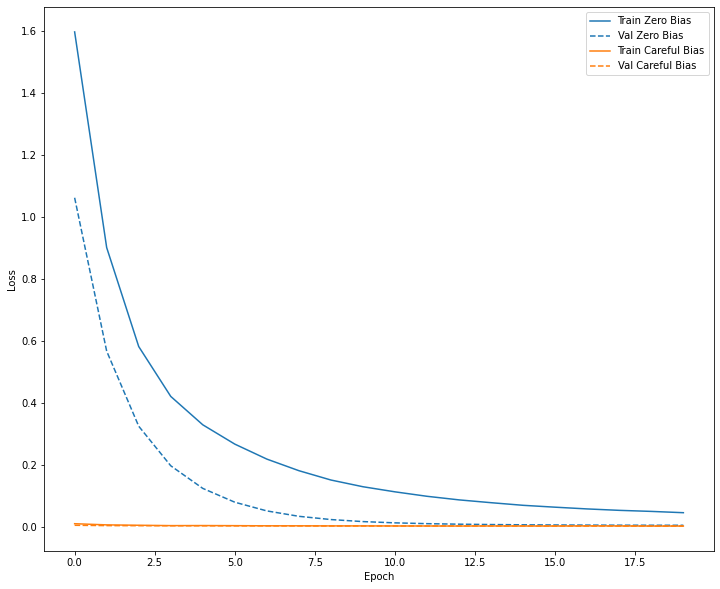

In [ ]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

Clearly the model with a careful initialization converges faster.

### Training the model

Given that, let's train the model:

In [ ]:
model = make_model(output_bias = initial_bias)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
90/90 [==============================] - 2s 18ms/step - loss: 0.0156 - tp: 100.0000 - fp: 241.0000 - tn: 227199.0000 - fn: 305.0000 - accuracy: 0.9976 - precision: 0.2933 - recall: 0.2469 - auc: 0.7819 - val_loss: 0.0075 - val_tp: 22.0000 - val_fp: 6.0000 - val_tn: 45484.0000 - val_fn: 57.0000 - val_accuracy: 0.9986 - val_precision: 0.7857 - val_recall: 0.2785 - val_auc: 0.8798
Epoch 2/100
90/90 [==============================] - 1s 9ms/step - loss: 0.0080 - tp: 129.0000 - fp: 33.0000 - tn: 181917.0000 - fn: 197.0000 - accuracy: 0.9987 - precision: 0.7963 - recall: 0.3957 - auc: 0.8957 - val_loss: 0.0060 - val_tp: 39.0000 - val_fp: 7.0000 - val_tn: 45483.0000 - val_fn: 40.0000 - val_accuracy: 0.9990 - val_precision: 0.8478 - val_recall: 0.4937 - val_auc: 0.8907
Epoch 3/100
90/90 [==============================] - 1s 10ms/step - loss: 0.0064 - tp: 146.0000 - fp: 23.0000 - tn: 181927.0000 - fn: 180.0000 - accuracy: 0.9989 - precision: 0.8639 - recall: 0.4479 - auc: 0.9152 - v

### Check training history

First, we write a function to plot the metrics.

In [ ]:
def plot_metrics(history,color_num = 0):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric],color = colors[color_num], 
             label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             colors[color_num], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

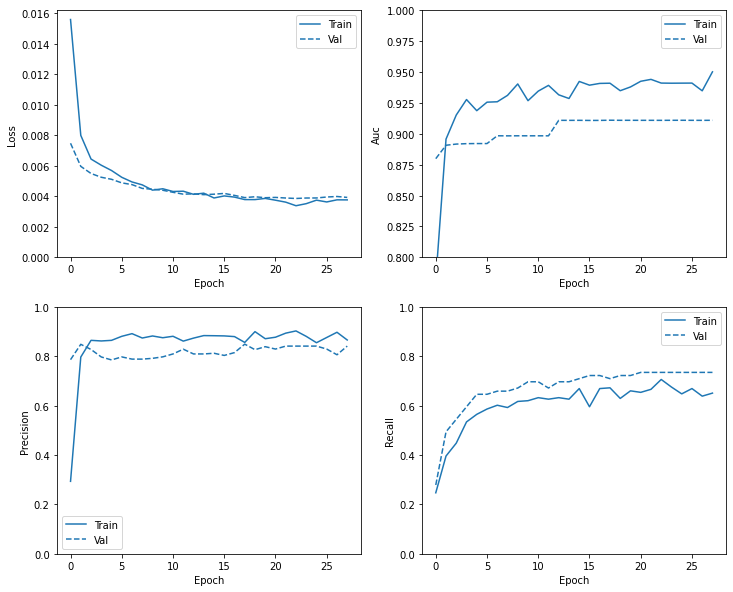

In [ ]:
plot_metrics(baseline_history, color_num = 0)

The model does is not overfitting. The validation curves are generally better than the training curves, which is due to the fact that during validation the Dropout layer is not active.

### Metrics evaluation

For this kind of problem, it is good to use a confusion matrix to get an idea of how well the model is classifying the positive and negative samples.



In [ ]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

We begin by writing a function to plot the confusion matrix, using sklearn.

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Let' evaluate how the model performs.

loss :  0.003030603751540184
tp :  64.0
fp :  11.0
tn :  56864.0
fn :  23.0
accuracy :  0.9994031190872192
precision :  0.8533333539962769
recall :  0.7356321811676025
auc :  0.9249842166900635

Legitimate Transactions Detected (True Negatives):  56864
Legitimate Transactions Incorrectly Detected (False Positives):  11
Fraudulent Transactions Missed (False Negatives):  23
Fraudulent Transactions Detected (True Positives):  64
Total Fraudulent Transactions:  87


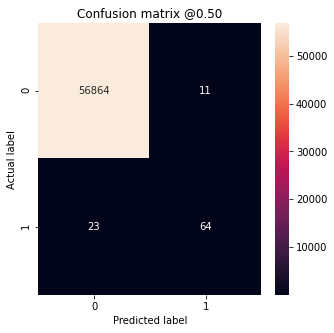

In [ ]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

The model has a precision of 87%, which means that whenever it calls positive, it is right in 87% of the time. However, the recall of 57% means that from all the positive samples, it detected only 57% of that, which means 54 frauds out of 94. It also classified only 8 legitimate transactions as frauds.

These are not good results in the context of this problem. Although the number of legitimate transactions classified as frauds is low, the number of undetected frauds is too high. Both cases decrease the customer's happiness, but surely the second case is far worse than the first, as it also will involve financial costs and lower the confidence the customer has in the bank security system. Therefore, it would be better to increase the number of detected frauds (true positives), even if that results in more legitimate transactions being classified as frauds (false positives). 

###Plot the ROC curve

Plot the ROC curve and calculate the AUC.

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-1,100.5])
  plt.ylim([-1,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

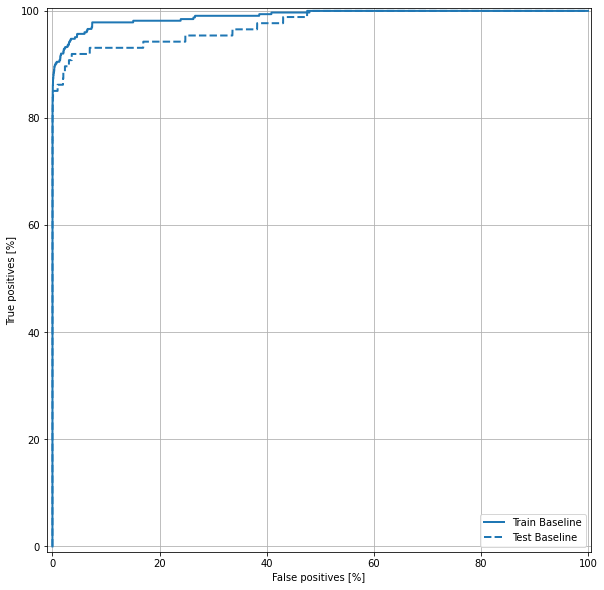

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

The AUC of 0.89 could be higher.

##Class weights

The fact that there are too few positive samples compared to the large amount of negative samples is a problem that cannot be neglected. A way to improve this model is to put weight on the positive samples, that is, forcing the model to "pay more attention" to the positive samples. This is done by passing Keras weights for each class through a parameter. 

Let's see how this improve our results. First, we need to define the weights:

In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


The scaling by total/2 is needed to keep the loss to a similar magnitude. 

### Train a model with class weights



In [ ]:
weighted_model = make_model(output_bias = initial_bias)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    class_weight=class_weight # Here we define the class weights
    ) 

Epoch 1/100
90/90 [==============================] - 2s 18ms/step - loss: 3.0186 - tp: 89.0000 - fp: 43.0000 - tn: 238782.0000 - fn: 324.0000 - accuracy: 0.9985 - precision: 0.6742 - recall: 0.2155 - auc: 0.7165 - val_loss: 0.0079 - val_tp: 4.0000 - val_fp: 0.0000e+00 - val_tn: 45490.0000 - val_fn: 75.0000 - val_accuracy: 0.9984 - val_precision: 1.0000 - val_recall: 0.0506 - val_auc: 0.8779
Epoch 2/100
90/90 [==============================] - 1s 9ms/step - loss: 1.4783 - tp: 122.0000 - fp: 127.0000 - tn: 181823.0000 - fn: 204.0000 - accuracy: 0.9982 - precision: 0.4900 - recall: 0.3742 - auc: 0.8244 - val_loss: 0.0071 - val_tp: 54.0000 - val_fp: 13.0000 - val_tn: 45477.0000 - val_fn: 25.0000 - val_accuracy: 0.9992 - val_precision: 0.8060 - val_recall: 0.6835 - val_auc: 0.9154
Epoch 3/100
90/90 [==============================] - 1s 10ms/step - loss: 0.7616 - tp: 209.0000 - fp: 268.0000 - tn: 181682.0000 - fn: 117.0000 - accuracy: 0.9979 - precision: 0.4382 - recall: 0.6411 - auc: 0.9152

### Check training history

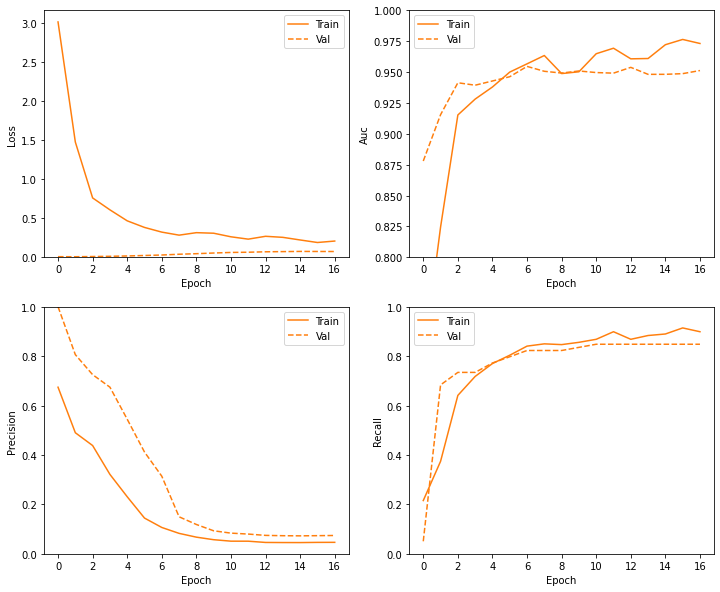

In [ ]:
plot_metrics(weighted_history,color_num=1)

### Evaluate metrics:

loss :  0.027062147855758667
tp :  74.0
fp :  167.0
tn :  56708.0
fn :  13.0
accuracy :  0.9968400001525879
precision :  0.30705395340919495
recall :  0.8505747318267822
auc :  0.9699784517288208

Legitimate Transactions Detected (True Negatives):  56708
Legitimate Transactions Incorrectly Detected (False Positives):  167
Fraudulent Transactions Missed (False Negatives):  13
Fraudulent Transactions Detected (True Positives):  74
Total Fraudulent Transactions:  87


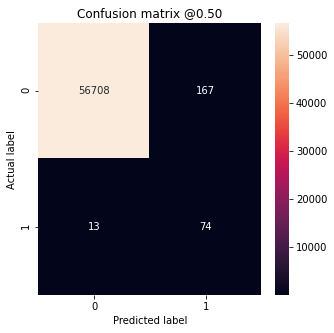

In [ ]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

With the class weights, the model could detect 89% of the fradulent transactions (84 out of 94), with an AUC of 0.97. This is a nice result, but comes with the downside of classifying 996 legitimate transactions as fraudulent. But, as discussed before, this is better than missing positive samples. This is all reflected by the high recall the high recall (0.89) and low precision (0.07).


###Plot the ROC curve

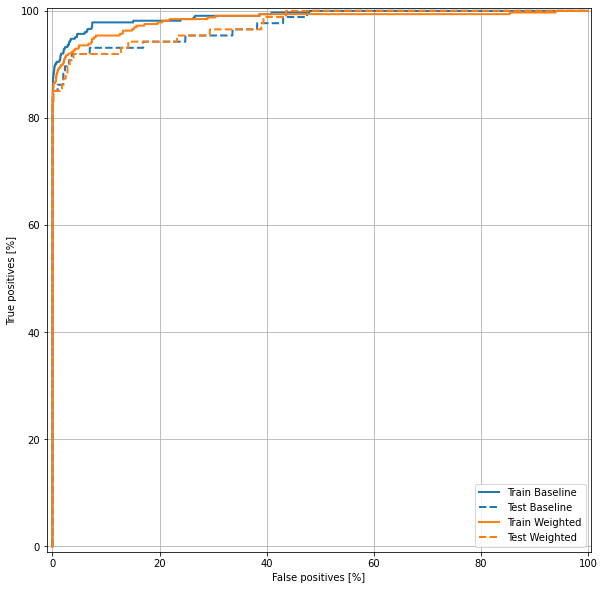

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right')

## Random undersampling 

A second alternative to solve the imbalance problem is to implement "Random Under Sampling", which consists of removing data from the majority class (non-fraud) in oredr to have a balanced dataset.

1. First, we determine how many fraud samples there are (we already did this there are 492 fraud samples)
2. Then, we bring that same amount of non-fraud transactions (chosen randomly) and put them together into a new dataframe, which will have a 50/50 ratio of fraud and non-fraud transactions. 

The problem with doing the Random under-sampling is the risk to lose information, as we are taking only 492 non-fraud samples from a set of 284,314. 

In [ ]:
# amount of fraud classes 492 rows.
fraud_df = cleaned_df.loc[cleaned_df['Class'] == 1]
non_fraud_df = cleaned_df.loc[cleaned_df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
under_df = normal_distributed_df.sample(frac=1, random_state=42)

under_df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,Log Amount
count,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000
mean,-2.467403,1.905304,-3.083884,2.456780,-1.561726,-0.572584,-2.730903,0.261082,-1.301145,-2.805194,1.952535,-2.995317,-0.090291,-3.597227,0.062751,-2.157125,-3.366095,-1.218706,0.335945,0.211179,0.354898,-0.044481,-0.036529,-0.047380,0.087571,0.026120,0.096182,0.027865,0.500000,2.493201
std,5.407122,3.596109,6.435905,3.042722,4.202692,1.803657,5.863242,4.850081,2.266780,4.549493,2.736980,4.657383,1.010213,4.568241,1.002187,3.424393,5.953541,2.358768,1.284338,1.061353,2.787267,1.145080,1.148960,0.586683,0.640419,0.468299,1.003732,0.442955,0.500254,2.658696
min,-30.552380,-12.114213,-31.103685,-4.515824,-22.105532,-6.406267,-43.557242,-41.044261,-13.434066,-24.588262,-2.332011,-18.683715,-3.127795,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-3.681904,-4.128186,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.243924,-7.263482,-2.733887,0.000000,-6.907755
25%,-2.788129,0.085200,-5.084967,0.345951,-1.692661,-1.442584,-3.060742,-0.170996,-2.222204,-4.572043,-0.188237,-5.495221,-0.786301,-6.721799,-0.510123,-3.543426,-5.317584,-1.853739,-0.488002,-0.166192,-0.173785,-0.533915,-0.226458,-0.415078,-0.216776,-0.296613,-0.039310,-0.049952,0.000000,0.582774
50%,-0.781327,0.954502,-0.309446,1.383210,-0.390293,-0.510317,-0.433163,0.153493,-0.584912,-0.594065,1.199952,-0.514868,-0.047583,-1.041415,0.148834,-0.728592,-0.510419,-0.479214,0.224047,0.052782,0.093024,-0.028825,-0.050720,0.027849,0.127459,-0.015632,0.065185,0.037457,0.500000,2.767010
75%,0.870308,2.726800,0.934280,4.175332,0.427009,0.233236,0.304743,0.808184,0.114193,-0.000161,3.586130,0.326755,0.652979,-0.040879,0.786409,0.189180,0.187781,0.190446,1.002454,0.414730,0.713646,0.440345,0.142884,0.393393,0.456121,0.308815,0.455031,0.217936,1.000000,4.535160
max,2.132386,22.057729,3.772857,12.114672,11.095089,6.474115,5.802537,20.007208,5.436633,8.737458,12.018913,2.152055,2.815440,3.442422,2.471358,3.139656,6.739384,3.790316,5.228342,11.059004,27.202839,8.361985,5.466230,1.215279,2.208209,3.065576,3.052358,1.779364,1.000000,8.250108


In [ ]:
neg_under, pos_under = np.bincount(under_df['Class'])
total_under = neg_under + pos_under
print('Examples:\n  Total: {}\n  Negative: {} ({:.2f}% of total)\n  Positive: {} ({:.2f}% of total)\n'.format(
    total_under, neg, 100 * neg_under / total_under, pos_under, 100 * pos_under / total_under))

Examples:
  Total: 984
  Negative: 284315 (50.00% of total)
  Positive: 492 (50.00% of total)



Now we have a subset with 984 samples.

In [ ]:
train_under_df, test_under_df = train_test_split(under_df, test_size=0.2)
train_under_df, val_under_df = train_test_split(train_under_df, test_size=0.2)

train_under_labels = np.array(train_under_df.pop('Class'))
bool_train_under_labels = train_under_labels != 0
val_under_labels = np.array(val_under_df.pop('Class'))
test_under_labels = np.array(test_under_df.pop('Class'))

train_under_features = np.array(train_under_df)
val_under_features = np.array(val_under_df)
test_under_features = np.array(test_under_df)

In [ ]:
neg_under_train, pos_under_train = np.bincount(train_under_labels)
total_under_train = neg_under_train + pos_under_train

neg_under_val, pos_under_val = np.bincount(val_under_labels)
total_under_val = neg_under_val + pos_under_val

neg_under_test, pos_under_test = np.bincount(test_under_labels)
total_under_test = neg_under_test + pos_under_test

print('Train:\n  Total: {}\n  Negative: {} ({:.2f}% of total)\n  Positive: {} ({:.2f}% of total)\n'.format(
    total_under_train, neg_under_train, 100 * neg_under_train / total_under_train,
    pos_under_train, 100 * pos_under_train / total_under_train))

print('Validation:\n  Total: {}\n  Negative: {} ({:.2f}% of total)\n  Positive: {} ({:.2f}% of total)\n'.format(
    total_under_val, neg_under_val, 100 * neg_under_val / total_under_val, 
    pos_under_val, 100 * pos_under_val / total_under_val))

print('Test:\n  Total: {}\n  Negative: {} ({:.2f}% of total)\n  Positive: {} ({:.2f}% of total)\n'.format(
    total_under_val, neg_under_test, 100 * neg_under_test / total_under_test, 
    pos_under_test, 100 * pos_under_test / total_under_test))

Train:
  Total: 629
  Negative: 316 (50.24% of total)
  Positive: 313 (49.76% of total)

Validation:
  Total: 158
  Negative: 76 (48.10% of total)
  Positive: 82 (51.90% of total)

Test:
  Total: 158
  Negative: 100 (50.76% of total)
  Positive: 97 (49.24% of total)



Let's do the standard scale again.

In [ ]:
scaler = StandardScaler()
train_under_features = scaler.fit_transform(train_under_features)

val_under_features = scaler.transform(val_under_features)
test_under_features = scaler.transform(test_under_features)

#The np.clip helps setting all the features to be in the range [-5,5] (values 
#lower than -5 and higher than 5 are set to -5 and 5, respectively)

train_under_features = np.clip(train_under_features, -5, 5)
val_under_features = np.clip(val_under_features, -5, 5)
test_under_features = np.clip(test_under_features, -5, 5)


print('Training labels shape:', train_under_labels.shape)
print('Validation labels shape:', val_under_labels.shape)
print('Test labels shape:', test_under_labels.shape)

print('Training features shape:', train_under_features.shape)
print('Validation features shape:', val_under_features.shape)
print('Test features shape:', test_under_features.shape)

Training labels shape: (629,)
Validation labels shape: (158,)
Test labels shape: (197,)
Training features shape: (629, 29)
Validation features shape: (158, 29)
Test features shape: (197, 29)


### Train a model with random under-sampling

As now the two classes are balanced, there we can initialize the model with the default bias. Let's test run it:

In [ ]:
under_model = make_model()

train_under_labels[:10]

array([1, 0, 1, 1, 0, 1, 1, 0, 0, 0])

In [ ]:
under_model.predict(train_under_features[:10])

array([[0.69854575],
       [0.48708302],
       [0.60970306],
       [0.69120026],
       [0.53317857],
       [0.83703685],
       [0.501963  ],
       [0.4557706 ],
       [0.5360644 ],
       [0.6739315 ]], dtype=float32)

In [ ]:
(under_model.predict(train_under_features[:10]) > 0.5).astype("int32")

array([[1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1]], dtype=int32)

This is what is expected for the initial guesses, as now the dataset is balanced.

In [ ]:
#Now we don't need to use a huge batch size as the classes are balanced
BATCH_SIZE = 32

results = under_model.evaluate(train_under_features, train_under_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6363


The initial loss is around the expected value of $ln(2) = 0.6931$.

In [ ]:
under_history = under_model.fit(
    train_under_features,
    train_under_labels,    
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_under_features, val_under_labels)
    ) 

Epoch 1/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6890 - tp: 229.0000 - fp: 156.0000 - tn: 160.0000 - fn: 84.0000 - accuracy: 0.6184 - precision: 0.5948 - recall: 0.7316 - auc: 0.6975 - val_loss: 0.5350 - val_tp: 59.0000 - val_fp: 21.0000 - val_tn: 55.0000 - val_fn: 23.0000 - val_accuracy: 0.7215 - val_precision: 0.7375 - val_recall: 0.7195 - val_auc: 0.8092
Epoch 2/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5787 - tp: 234.0000 - fp: 111.0000 - tn: 205.0000 - fn: 79.0000 - accuracy: 0.6979 - precision: 0.6783 - recall: 0.7476 - auc: 0.7823 - val_loss: 0.4608 - val_tp: 59.0000 - val_fp: 4.0000 - val_tn: 72.0000 - val_fn: 23.0000 - val_accuracy: 0.8291 - val_precision: 0.9365 - val_recall: 0.7195 - val_auc: 0.8476
Epoch 3/100
20/20 [==============================] - 0s 3ms/step - loss: 0.4862 - tp: 243.0000 - fp: 76.0000 - tn: 240.0000 - fn: 70.0000 - accuracy: 0.7679 - precision: 0.7618 - recall: 0.7764 - auc: 0.8445 - val_loss: 0.4187 - 

### Check training history

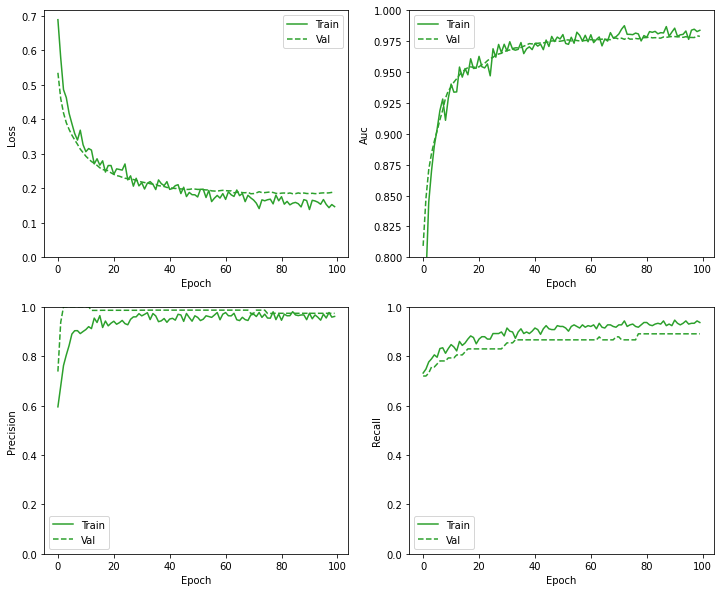

In [ ]:
plot_metrics(under_history,color_num=2)

The model is not overfitting.

###Evaluate metrics

loss :  0.0644613578915596
tp :  95.0
fp :  0.0
tn :  100.0
fn :  2.0
accuracy :  0.989847719669342
precision :  1.0
recall :  0.9793814420700073
auc :  0.9994329810142517

Legitimate Transactions Detected (True Negatives):  100
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  2
Fraudulent Transactions Detected (True Positives):  95
Total Fraudulent Transactions:  97


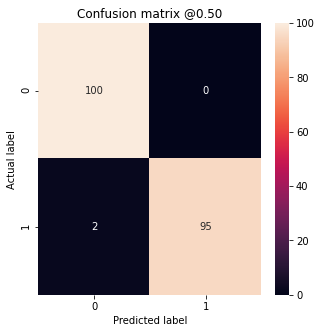

In [ ]:
train_predictions_under = under_model.predict(train_under_features, batch_size=BATCH_SIZE)
test_predictions_under = under_model.predict(test_under_features, batch_size=BATCH_SIZE)

under_results = under_model.evaluate(test_under_features, test_under_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(under_model.metrics_names, under_results):
  print(name, ': ', value)
print()

plot_cm(test_under_labels, test_predictions_under)

This is a very good result. We only 5 undetected frauds out of 105, and 1 legitimate transaction classified as a fraud. This gives us a high recall of 95%, but also a great precision of 99%, which is better than the class weight model which gave a good recall, but a bad precision. Therefore, undersampling seems like a good approach to the problem.

###Plot the ROC curve

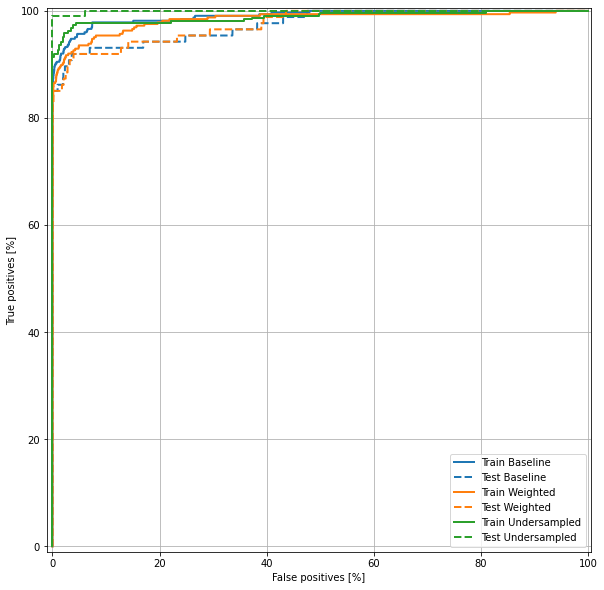

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Undersampled", train_under_labels, train_predictions_under, color=colors[2])
plot_roc("Test Undersampled", test_under_labels, test_predictions_under, color=colors[2], linestyle='--')

plt.legend(loc='lower right')

##Oversampling

A third way to deal with the imbalanced dataset is to oversample the dataset with the minority class.

In [ ]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape